<a href="https://colab.research.google.com/github/lilydia/Amazon_Product_Reviews_Analysis/blob/master/SentimentAnalysis_Py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gzip
import json
import os
import string
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

nltk.download('stopwords')
nltk.download('vader_lexicon')
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz #get amazon dataset

In [7]:
##### LOADING DATA
data = []
with gzip.open('meta_Computers.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    

print("-- VIEW TOTAL # OF PRODUCTS:")
print(len(data))
print("-- VIEW PRODUCT DETAILS:")
print(data[0])


df = pd.DataFrame.from_dict(data)
print("-- CONFIRM LIST->DATAFRAME CONVERSION:")
print(len(df))

-- VIEW TOTAL # OF PRODUCTS:
18772
-- VIEW PRODUCT DETAILS:
{'description': ['Brand new. Still in factory-sealed plastic.'], 'title': 'Kelby Training DVD: The Adobe Photoshop CS5 7-Point System for Camera Raw By Scott Kelby', 'image': ['https://images-na.ssl-images-amazon.com/images/I/31IlLImCVJL._SS40_.jpg'], 'brand': 'Kelby Training', 'rank': ['>#654,681 in Electronics (See Top 100 in Electronics)'], 'main_cat': 'Computers', 'date': 'December 2, 2011', 'asin': '0321732960'}
-- CONFIRM LIST->DATAFRAME CONVERSION:
18772


In [8]:
##### CLEANING DATA

df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # isolate unformatted rows (ie. content in html format)
df5 = df3[~df3.title.str.contains('getTime')] # remove those unformatted rows
print("-- # OF REMOVED PRODUCTS:")
print(len(df4))
print("-- # OF PRODUCTS AFTER CLEANING:")
print(len(df5))
print("-- CONFIRM DELETED CONTENT:")
print(df4.iloc[0])


-- # OF REMOVED PRODUCTS:
135
-- # OF PRODUCTS AFTER CLEANING:
18637
-- CONFIRM DELETED CONTENT:
description                                                      
title           var aPageStart = (new Date()).getTime();\nvar ...
image                                                            
brand                                              DS Miller Inc.
rank            [>#1,826,312 in Electronics (See Top 100 in El...
main_cat                                                Computers
date                                                March 1, 2010
asin                                                   B0016C5EXY
feature                                                          
tech1                                                            
also_buy                                                         
price                                                            
also_view                                                        
tech2                                        

In [9]:
df5.shape #check dataframe shape

(18637, 16)

In [10]:
print(df5.iloc[0]) #look at the 16 columns

description         [Brand new. Still in factory-sealed plastic.]
title           Kelby Training DVD: The Adobe Photoshop CS5 7-...
image           [https://images-na.ssl-images-amazon.com/image...
brand                                              Kelby Training
rank            [>#654,681 in Electronics (See Top 100 in Elec...
main_cat                                                Computers
date                                             December 2, 2011
asin                                                   0321732960
feature                                                          
tech1                                                            
also_buy                                                         
price                                                            
also_view                                                        
tech2                                                            
details                                                          
similar_it

In [11]:
df5['description'] #look into area of interest

0            [Brand new. Still in factory-sealed plastic.]
1        [If you're already a Photoshop user and want a...
2        [School To Home Notes: Note From the Teacher!\...
3        [Dooqi is a young brand specializing in high-e...
4                                      [Cover for Nook HD]
                               ...                        
18767                                                     
18768                                                     
18769    [Deadpool is a mercenary and anti-hero appeari...
18770                                                     
18771                                                     
Name: description, Length: 18637, dtype: object

In [12]:
##### TRANSFORMING DATA FOR TEXT ANALYTICS

def remove_punctuation(text):
  no_punct = "".join([w for w in text if w not in string.punctuation])
  return no_punct

def isolate_word(text):
  tokenizer = RegexpTokenizer(r'\w+')
  return tokenizer.tokenize(text.lower())

#stopwords like "i, me, my, myself, you, he, she"
def remove_stopword(text):
  no_stop = [w for w in text if w not in stopwords.words('english')]
  return no_stop

reviews_df = df5['description']
reviews_df_try = reviews_df.apply(lambda x : remove_punctuation(x))
reviews_df = reviews_df_try.apply(lambda x : remove_punctuation(x))
reviews_df = reviews_df.apply(lambda x : isolate_word(x))
reviews_df = reviews_df.apply(lambda x : remove_stopword(x))

reviews_df.head()


0          [brand, new, still, factorysealed, plastic]
1    [youre, already, photoshop, user, want, quick,...
2    [school, home, notes, note, teachernsuitable, ...
3    [dooqi, young, brand, specializing, highend, s...
4                                    [cover, nook, hd]
Name: description, dtype: object

In [ ]:
#####STEMMING VS. LEMMATIZING
#convert prefixes and endings to root forms



In [168]:
##### SENTIMENT ANALYSIS

def sentiment_analyse_test(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    if score['neg'] > score['pos']:
        print("Negative Sentiment detected in: "+ "[" + text + "]" )
    elif score['neg'] < score['pos']:
        print("Positive Sentiment detected in: "+ "[" + text + "]")
    else:
        print("Neutral Sentiment detected in: "+ "[" + text + "]")

#testing outcomes
sentiment_analyse_test("I do not recommend this product.")
sentiment_analyse_test("I am happy about the purchase.")
sentiment_analyse_test("Brand new packaging. Ready to be used.")

sample_review = df5.description[0]
# Convert to string
full_str = ' '.join([str(elem) for elem in sample_review])

sentiment_analyse_test(full_str)

Negative Sentiment detected in: [I do not recommend this product.]
Positive Sentiment detected in: [I am happy about the purchase.]
Positive Sentiment detected in: [Brand new packaging. Ready to be used.]
Neutral Sentiment detected in: [Brand new. Still in factory-sealed plastic.]


In [17]:
sents = []
from collections import Counter

def sentiment_analyse(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    if score['neg'] > score['pos']:
        return 'NEGATIVE'
    elif score['neg'] < score['pos']:
        return 'POSITIVE'
    else:
        return 'NEUTRAL'

for product in reviews_df:
  full_str = ' '.join([str(elem) for elem in product])
  sents.append(sentiment_analyse(full_str))

w = Counter(sents)
print(w)  


Counter({'NEUTRAL': 15152, 'POSITIVE': 3166, 'NEGATIVE': 319})


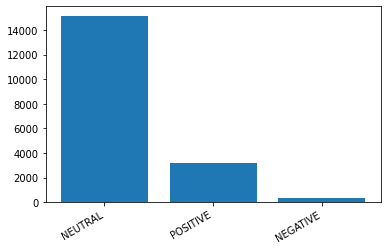

In [18]:
import matplotlib.pyplot as plt

#####PLOTTING DATA
fig, ax1 = plt.subplots()
ax1.bar(w.keys(), w.values())
fig.autofmt_xdate()
plt.savefig('graph.png')
plt.show()